# Empirical Analysis of Early Stopping and Learning Rate Scheduling for Deep Learning on Resource-Constrained Hardware

This file serves as the codebase for doing the experimentations done in the paper entitled as ***"Empirical Analysis of Early Stopping and Learning Rate Scheduling for Deep Learning on Resource-Constrained Hardware"***.

This specific file serves as the GPU testing notebook, separating it from the [Colab](./colab.ipynb) and [CPU](./cpu.ipynb) experimentation notebooks.

**Purpose:**

To provide an empirical analysis on how specific training optimizations perform under resource-constrained hardwares. This explores consumer-grade hardware typically accessible to students and researchers with limited resources, allowing a large part of the Deep Learning community to be able to run potentially more complex tasks on such readily available devices.

## Imports

All needed libraries will be imported here.

Unless conditional, all imports must be done in this section to prevent workspace cluttering. Imports are sorted in an ascending manner, starting from "a" to "Z".

In [19]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Any, Dict, Union
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import random
import seaborn as sns
import subprocess as sp
import tensorflow as tf
import time

try:
    import GPUtil
    gputil_exist = True
except ImportError:
    gputil_exist = False

if (os.name == 'nt'):
    import wmi
    import winsound

%matplotlib inline

## Data and Variables

Sets all the global data and variables here.

Global variables will be defined and instantiated in this section, preventing a confusing clutter down the line and allowing readability when revisions are needed.

### Instantiations

Instantiations of objects will be done here, preventing mixture of variable preview and definition.

#### Variables

Variable instantiations

##### Dataset and Model Variables

All dataset and model related variables are defined here, separated from the logger related ones, allowing cohesion in the already chaotic ~~world~~ notebook.

In [20]:

data = {
    'class_names': [
		'airplane', 'automobile', 'bird', 'cat', 'deer',
		'dog', 'frog', 'horse', 'ship', 'truck'
    ],
	'train': {
		'x': None,
		'y': None,
	},
	'test': {
		'x': None,
		'y': None,
	},
    'val': None,
}
(data['train']['x'], data['train']['y']), (data['test']['x'], data['test']['y']) = tf.keras.datasets.cifar10.load_data()

callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        verbose = 2,
        restore_best_weights = True
    ),
    # ReduceLROnPlateau(
    #     monitor = 'val_loss',
    #     factor = 0.5,
    #     patience = 5,
    #     verbose = 2,
    #     min_lr = 1e-6
    # )
]

save_plots = True

None

##### Metrics related variables

(Static) Variables that will be used by the metric logger. Some variables are localized to the country where the researcher is based.

When recreating the experiment, feel free to modify the values of the following variables to match your location's costs:

- `local_currency_name`: The name of your local currency *(i.e.: Philippine Peso -> `"peso"`)*
- `to_usd_conversion`: The cost of your location's currency to USD.
- `cost_per_kwh_local`: The killowatt/hour cost in your location. Use local currency values.

Some other variables are also changeable to allow the researcher(s) to easily update their values such as the `cpu_tdp`:

- `platform`: The platform on where the experiment was done. In the researcher's case, it is `"RTX 3050 Ti Laptop"`.
- `cpu_tdp`: The CPU's themal design power (TDP) in watts. This is different for every CPU.
- `room_temp`: The current room temperature of where the hardware is located while the experiment is being conducted.

These last two variables are for the logging:

- `prefix`: The location on where the log will be saved. Could be a relative or an absolute path.
- `file_name`: The name of the log file. Must be a JSON format... but realistically, it could be any file extension. In the end, it'll still log it in JSON. ~~LMAO~~

In [ ]:
# The local currency used by the researcher (PHP -> peso)
local_currency_name = "peso"
"""
Defines the name of the local currency used by the researcher. This is to simplify
and allow flexible changes to the local currency when someone wishes to recreate the
experiment in a different country or region.
"""

# As of May 30, 2025 (PHP -> USD)
to_usd_conversion = 0.018
"""
Defines the conversion rate of the local currency to US Dollar.
"""

# kwh in local currency (in this case, PHP)
cost_per_kwh_local = 13.01
"""
A fixed cost per kilowatt-hour in the local currency; the currency used by the country where
the researcher is based.
"""

# kwh in US Dollar
cost_per_kwh_usd = cost_per_kwh_local * to_usd_conversion
"""
A dollar conversion of the cost per kilowatt-hour from the local currency.
"""

platform = "RTX 3050 Ti Laptop"
"""
Defines the platform used for the experiment.
"""

cpu_tdp = 45
"""
Defines the thermal design power (TDP) of the CPU in watts.
"""

env_temp = 30
"""
Manual temperature setting for the time the experiment was conducted. The researcher used the
location's temperature based on the weather station at the time of the experiment. However,
it would be better to use a temperature sensor to get the temperature of the room where the
experiment was conducted for a more accurate result.

Temperature is in degrees Celsius.
"""

prefix = "./../out/gpu"
"""
Defines the output directory for the training metrics.
"""

file_name = lambda postfix=None: f"{prefix}/training_metrics{f'-{postfix}' if postfix is not None and len(postfix) > 0 else ''}.log"
"""
Defines the file name for the training metrics.
"""

file_postfix = f"{platform.replace(' ', '_')}"
"""
A postfix for the output files to differentiate between different runs or experiments.
This can be used to append a unique identifier or timestamp to the file name.
"""

for strat in callbacks:
    file_postfix += f"-{strat.__class__.__name__}"
    
None

#### Functions

Function creation

##### Helper Functions

In [22]:
def showImg(input, title = None, axis = False):
    """
    Displays an image.

    :param input: The image to display.
    :type input: numpy.ndarray
    
    :param title: Title of the image.
    :type title: str

    :param axis: Whether to show the axis or not.
    :type axis: bool
    """
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    if not axis:
        plt.axis('off')
    plt.show()

None

##### Logger Related Functions

In [ ]:
def log_metrics(metrics: Dict[str, Any], platform: str, lr_strategy: str):
    """
    Logs the training metrics to a JSON file, including the platform (manual input) and
    learning rate strategy (manual input). Some metrics are fixed and are defined in the
    global variables section (under `Metrics related variables`).

    The metrics that are logged include:
    - `epoch`: The epoch in which the metrics were recorded.
    - `loss`: The loss value at the end of the epoch.
    - `accuracy`: The accuracy value at the end of the epoch.
    - `training_time_hours`: The total training time in hours.
    - `platform`: The platform on which the training was performed (manual input).
    - `lr_strategy`: The learning rate strategy used during training (manual input).
    - `room_temp`: The room temperature during training (under `Metrics related variables`).
    - `cpu_percent`: The CPU usage (in percentage) during training.
    - `cpu_power`: The CPU power consumption (in watts) during training.
    - `gpu_load`: The GPU load (in percentage) during training.
    - `gpu_power`: The GPU power consumption (in watts) during training.
    - `accuracy_per_watt`: The accuracy per watt, calculated as `accuracy / (gpu_power + cpu_power)`.
    - `convergence_per_local_currency`: The convergence per local currency, calculated as `accuracy / ((gpu_power + cpu_power) * training_time_hours * cost_per_kwh_local_currency)`.
    - `convergence_per_dollar`: The convergence per dollar, calculated as `accuracy / ((gpu_power + cpu_power) * training_time_hours * cost_per_kwh_usd)`.
    - `timestamp`: The timestamp when the metrics were logged.

    **NOTE:** The `..._local_currency` refers to the local currency used by the researcher, which is defined in the global variables section.
    This may be changed to a different currency to reflect the local currency of the researcher.
    In the original experiment, the local currency is the Philippine peso (PHP). The variable is named `cost_per_kwh_local` so that it is easy
    to understand that this could be changed easily into other local currency anyone wishes to use.

    :param metrics: The training metrics to log.
    :type metrics: dict

    :param platform: The platform on which the training was performed.
    :type platform: str

    :param lr_strategy: The learning rate strategy used during training.
    :type lr_strategy: str
    """
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    # Add new fields to the metrics dictionary
    metrics['platform'] = platform
    metrics['lr_strategy'] = lr_strategy
    metrics['env_temp'] = env_temp

    get_cpu_metrics(metrics)
    get_gpu_metrics(metrics)

    # Other metrics
    effective_power = {
        "cpu": metrics.get("cpu_power", 0),
        "gpu": metrics.get("gpu_power", 0)
    }

    if type(effective_power["cpu"]) not in (int, float):
        effective_power["cpu"] = 0
    if type(effective_power["gpu"]) not in (int, float):
        effective_power["gpu"] = 0

    total_power = effective_power["cpu"] + effective_power["gpu"]

    ## Accuracy per watt
    metrics['accuracy_per_watt'] = metrics['accuracy'] / total_power if total_power > 0 else "N/A (No power consumption)"

    # Covergence per peso and dollar
    training_time_hours = metrics.get("training_time_hours", 0)
    total_cost_local = (total_power / 1000) * training_time_hours * cost_per_kwh_local

    metrics[f"convergence_per_{local_currency_name}"] = metrics.get("accuracy", 0) / total_cost_local if total_cost_local > 0 else 0
    metrics["convergence_per_dollar"] = metrics.get("accuracy", 0) / (total_cost_local * to_usd_conversion) if total_cost_local > 0 else 0

    metrics['timestamp'] = timestamp      

    with open(file_name(file_postfix), "a") as log:
        log.write(json.dumps(metrics) + "\n")

    print(metrics)

def get_cpu_metrics(metrics: Dict[str, Any]):
    """
    Gets the CPU metrics and adds them to the metrics dictionary.

    :param metrics: The training metrics to log.
    :type metrics: dict
    """
    try:
        if (os.name == 'nt'):
            c = wmi.WMI()

            # cpu_tdp is defined at the "Metrics related variables" section.
            metrics["cpu_percent"] = c.Win32_Processor()[0].LoadPercentage
            metrics["cpu_power"] = (metrics["cpu_percent"] / 100) * cpu_tdp
        else:
            metrics["cpu_percent"] = psutil.cpu_percent(interval = None)

            # The current method of estimating CPU power is not available on Linux/macOS.
            # Please recode this part if you want to use a different method.
            metrics["cpu_power"] = "N/A (OS now Windows; TDP estimate not available)"
            print("Note: CPU power estimation via TDP is currently configured for Windows. For Linux/macOS, direct wattage might require other libraries/tools.")
    except Exception as e:
        metrics['cpu_percent'] = "Error"
        metrics['cpu_power'] = "Error"
        print(f"Error getting CPU metrics: {e}")

def get_gpu_metrics(metrics: Dict[str, Any]):
    """
    Gets the GPU metrics and adds them to the metrics dictionary.

    :param metrics: The training metrics to log.
    :type metrics: dict
    """
    metrics["gpu_load"] = "N/A"
    metrics["gpu_power"] = "N/A"

    if gputil_exist:
        try:
            gpus = GPUtil.getGPUs()

            if gpus:
                metrics["gpu_load"] = gpus[0].load * 100  # Convert to percentage

                try:
                    # Attempt to get GPU power using nvidia-smi
                    command = "nvidia-smi --query-gpu=power.draw --format=csv,noheader,nounits"
                    output = sp.check_output(command, shell=True).decode('utf-8').strip()
                    metrics["gpu_power"] = float(output) if output else 0.0
                except (sp.CalledProcessError, FileNotFoundError):
                    metrics["gpu_power"] = "N/A"
                except Exception:
                    metrics["gpu_power"] = "Error"
        except Exception as e:
            metrics["gpu_load"] = "Error" if metrics["gpu_load"] is None else metrics["gpu_load"]
            metrics["gpu_power"] = "Error" if metrics["gpu_power"] is None else metrics["gpu_power"]

None

In [24]:
# Custom callback class to log the metrics real-time during training.
class MetricLoggerCallback(Callback):
    """
    A custom callback to log training metrics and system performance during the training process,
    allowing the researcher to monitor crucial statistics for the experiment.
    """

    def __init__(self, platform: str, lr_strategy: str, start_time: Union[float, None] = None):
        super().__init__()

        self.platform = platform
        self.lr_strategy = lr_strategy
        self.start_time_session = start_time if start_time is not None else time.time()

    def on_epoch_end(self, epoch, logs = None):
        """
        Called at the end of each epoch to log the metrics and system performance.
        
        :param epoch: The current epoch number.
        :type epoch: int
        
        :param logs: A dictionary containing the metrics for the current epoch.
        :type logs: dict
        """
        logs = logs or {}

        # Calculate cumulative training time up to this epoch
        elapsed_time_seconds = time.time() - self.start_time_session
        training_time_hours = elapsed_time_seconds / 3600

        # Prepare metrics dictionary for the log_metrics function
        epoch_metrics = {
            "epoch": epoch + 1,  # Keras epochs are 0-indexed, so add 1 for logging
            "loss": logs.get('loss'),
            "accuracy": logs.get('accuracy'),
            "val_loss": logs.get('val_loss'),
            "val_accuracy": logs.get('val_accuracy'),
            "training_time_hours": training_time_hours
        }

        log_metrics(
            metrics = epoch_metrics,
            lr_strategy = self.lr_strategy,
            platform = self.platform
        )

None

##### Model Related Functions

In [25]:
def residual_block(x, filters, stride = 1):
    """
    Defines a standard ResNet residual block with two convolutional layers.
    Handles identity and projection shortcuts based on stride and filter changes.

    :param x: Input tensor to the residual block.
    :type x: tf.Tensor

    :param filters: Number of filters for the convolutional layers within the block.
    :type filters: int

    :param stride: Number of pixels to skip when applying the convolutional layers.
    :type stride: int

    :return x: Output tensor after applying the residual block operations.
    :rtype: tf.Tensor
    """
    shortcut = x
    
    # Downsample if the stride is not 1 or if the number of filters in the shortcut does not match
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='valid', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolutional layer in the residual path
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # ReLU after BN as per diagram for first conv

    # Second convolutional layer in the residual path
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x) # Second conv always stride 1
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the residual path output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x) # Final ReLU after addition for the block output
    
    return x

def build_resnet18(input_shape:tuple = (32, 32, 3), num_classes:int = 10, model_name:str = "ResNet18_CIFAR10_Functional"):
    """
    Builds the ResNet-18 model for CIFAR-10 classification using the Keras Functional API.

    This implementation closely follows the provided ResNet-18 architecture diagram
    (e.g., [resnet18_cifar10_diagram.png](./../resnet18_cifar10_diagram.png)) for CIFAR-10 specific configurations like initial
    filter counts and inclusion of Dropout.
    """
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    # Diagram: Conv2D (32, 3x3, stride=1)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Stage 1: Two residual blocks with 64 filters, stride 1 (no downsampling)
    # Diagram: Residual Block 1a (64->64), 1b (64->64)
    x = residual_block(x, 64, stride=1) # Residual Block 1a
    x = residual_block(x, 64, stride=1) # Residual Block 1b

    # Stage 2: Two residual blocks with 128 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 2a (64->128, stride=2), 2b (128->128)
    x = residual_block(x, 128, stride=2) # Residual Block 2a (downsamples spatial dims by 2)
    x = residual_block(x, 128, stride=1) # Residual Block 2b

    # Stage 3: Two residual blocks with 256 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 3a (128->256, stride=2), 3b (256->256)
    x = residual_block(x, 256, stride=2) # Residual Block 3a (downsamples spatial dims by 2)
    x = residual_block(x, 256, stride=1) # Residual Block 3b

    # Stage 4: Two residual blocks with 512 filters, first block has stride 2 (downsampling)
    # Diagram: Residual Block 4a (256->512, stride=2), 4b (512->512)
    x = residual_block(x, 512, stride=2) # Residual Block 4a (downsamples spatial dims by 2)
    x = residual_block(x, 512, stride=1) # Residual Block 4b

    # Final Layers
    # Diagram: AdaptiveAvgPool2D (4x4 -> 1x1) - GlobalAveragePooling2D is the Keras equivalent
    x = layers.GlobalAveragePooling2D()(x) # Output shape will be (batch_size, 512)

    # Diagram: Flatten (512,) - Redundant after GlobalAveragePooling2D, but included for explicit diagram steps
    x = layers.Flatten()(x)

    # Diagram: Dropout (p=0.5)
    x = layers.Dropout(0.5)(x)

    # Diagram: Dense (512 -> 10)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the Keras Model
    model = Model(inputs = input_tensor, outputs = outputs, name = model_name)
    return model

#### Processes

Some data processing like pixel normalization and such.

In [26]:
# Set seed for reproducibility. Starts with 42 then increment per experiment.
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [27]:
data['train']['x'] = data['train']['x'].astype('float32') / 255.0
data['test']['x'] = data['test']['x'].astype('float32') / 255.0

data['train']['y'] = data['train']['y'].flatten()
data['test']['y'] = data['test']['y'].flatten()

In [28]:
lr_strats = ""

for strat in callbacks:
    if callbacks.index(strat) > 0:
        lr_strats += " & "

    lr_strats += strat.__class__.__name__

callbacks.append(
    MetricLoggerCallback(
        platform = platform,
        lr_strategy = lr_strats,
        start_time = time.time()
    )
)

#### Preview

Preview the created and instantiated variables and functions.

In [29]:
print(f"Train data shape: {data['train']['x'].shape}, Train labels shape: {data['train']['y'].shape}")
print(f"Test data shape: {data['test']['x'].shape}, Test labels shape: {data['test']['y'].shape}")

Train data shape: (50000, 32, 32, 3), Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


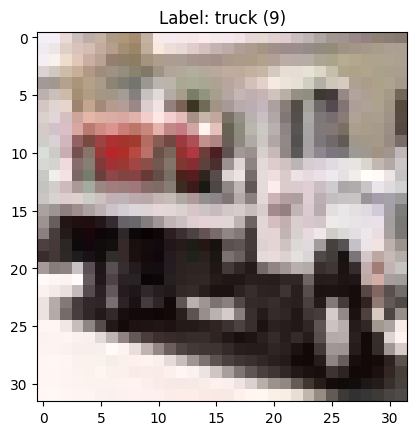

In [30]:
target = random.randint(0, len(data['train']['x']) - 1)
showImg(data['train']['x'][target], title = f"Label: {data['class_names'][data['train']['y'][target]]} ({data['train']['y'][target]})", axis = True)

## Process

Here begins the process which includes data splitting and pre-processing.

### Splitting the Data

In [31]:
# Already splitted...

### Pre-Processing

Image pre-processing, along with some image modification (skew, translate, etc.) are done here.

In [32]:
# Test Data
data['train']['generator'] = (ImageDataGenerator(
	rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)).flow(
	data['train']['x'],
	data['train']['y'],
)

# Validation Data
data['val'] = ImageDataGenerator(
    rescale = 1./255
).flow(
    data['test']['x'],
    data['test']['y'],
)

# Test Data
data['test']['generator'] = (ImageDataGenerator(
    rescale = 1./255,
)).flow(
	data['test']['x'],
	data['test']['y'],
    shuffle = False,
)

### Creating the Model

In [33]:
model = build_resnet18()
model.summary()

Model: "ResNet18_CIFAR10_Functional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 32, 32, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 32)  128         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 32, 32, 32)   0           ['batch

### Compilation and Training

In [34]:
model.compile(
    optimizer = Adam(learning_rate = 1e-4), # 0.0001
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [35]:
batch_size = 32
SPE = len(data['train']['x']) // batch_size
VS = len(data['test']['x']) // batch_size

print(f"Steps per epoch: {SPE}, Validation steps: {VS} (batch size: {batch_size})")

Steps per epoch: 1562, Validation steps: 312 (batch size: 32)


In [36]:
history = model.fit(
    data["train"]["generator"],
    steps_per_epoch = SPE,
    epochs = 100,
    validation_data = data["val"],
    validation_steps = VS,
    callbacks = callbacks
)

Epoch 1/100
1562/1562 [==============================] - 106s 65ms/step - loss: 1.9420 - accuracy: 0.3407 - val_loss: 1.7527 - val_accuracy: 0.4275
Epoch 2/100
1562/1562 [==============================] - 94s 60ms/step - loss: 1.4571 - accuracy: 0.4821 - val_loss: 1.3879 - val_accuracy: 0.5310
Epoch 3/100
1562/1562 [==============================] - 96s 61ms/step - loss: 1.2132 - accuracy: 0.5748 - val_loss: 1.4987 - val_accuracy: 0.5535
Epoch 4/100
1562/1562 [==============================] - 111s 71ms/step - loss: 1.0307 - accuracy: 0.6388 - val_loss: 1.3161 - val_accuracy: 0.6091
Epoch 5/100
1562/1562 [==============================] - 102s 65ms/step - loss: 0.9108 - accuracy: 0.6866 - val_loss: 0.8645 - val_accuracy: 0.6999
Epoch 6/100
1562/1562 [==============================] - 96s 61ms/step - loss: 0.8269 - accuracy: 0.7148 - val_loss: 0.7832 - val_accuracy: 0.7345
Epoch 7/100
1562/1562 [==============================] - 96s 62ms/step - loss: 0.7607 - accuracy: 0.7376 - val_loss

## Model Metrics Visualization

In [37]:
_, accuracy = model.evaluate(
    data["test"]["generator"],
    steps = VS,
    verbose = 2
)

312/312 - 6s - loss: 0.2971 - accuracy: 0.9051 - 6s/epoch - 18ms/step


In [38]:
y_pred = model.predict(
    data['test']['generator'],
    steps = VS,
    verbose = 1,
)

y_pred = np.argmax(y_pred, axis = 1)

312/312 [==============================] - 6s 16ms/step


In [39]:
print(len(y_pred))

y_pred.shape

9984


(9984,)

In [40]:
y_true = []
for _ in range(VS):
    _, labels = next(data["test"]["generator"])
    
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

y_true = np.array(y_true)

if len(y_true) != len(y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

print(len(y_true))

y_true.shape

9984


(9984,)

### Accuracy

In [58]:
print(f"Accuracy: {accuracy}")

accuracy *= 100

print(f"Accuracy (Updated): {accuracy:.2f}%")

Accuracy: 0.9051482081413269
Accuracy (Updated): 90.51%


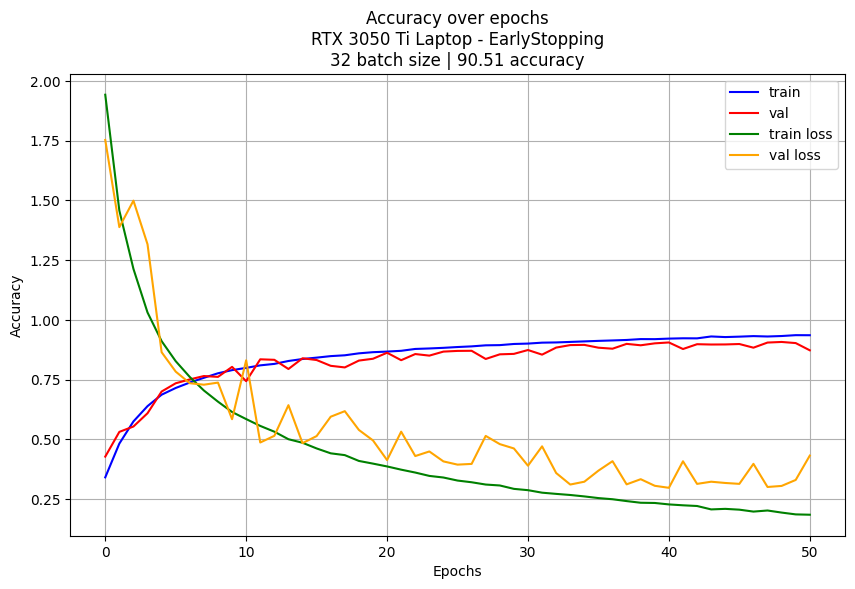

In [64]:
unixTime = int(datetime.datetime.now().timestamp() * 1e6)

plt.figure(figsize = (10, 6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
plt.plot(history.history['loss'], color = 'green', label = 'train loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val loss')
plt.legend()
plt.grid()
plt.title(f'Accuracy over epochs\n{platform} - {lr_strats}\n{data["train"]["generator"].batch_size} batch size | {accuracy:.2f} accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

if not os.path.exists(f"{prefix}/accuracy"):
    os.makedirs(f"{prefix}/accuracy")

if save_plots:
    plt.savefig(f"{prefix}/accuracy/{unixTime}-{accuracy:.2f}%-{file_postfix}.png")

### Confusion Matrix

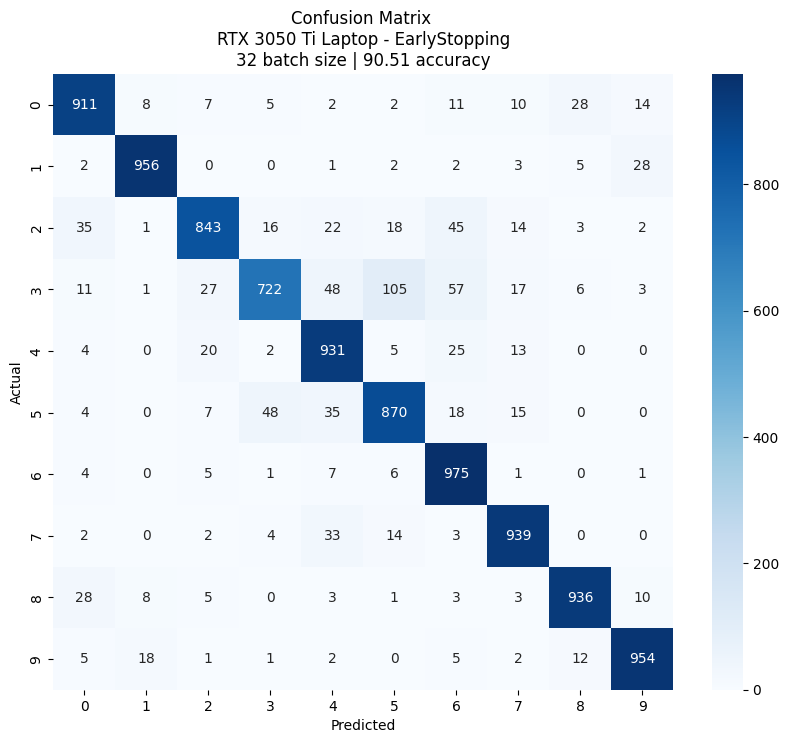

In [62]:
cm = confusion_matrix(
    y_true,
    y_pred
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')

plt.title(f'Confusion Matrix \n{platform} - {lr_strats}\n{data["train"]["generator"].batch_size} batch size | {accuracy:.2f} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

if not os.path.exists(f"{prefix}/confusion_matrix"):
    os.makedirs(f"{prefix}/confusion_matrix")

if save_plots:
    plt.savefig(f"{prefix}/confusion_matrix/{unixTime}-{accuracy:.2f}%-{file_postfix}.png")

## Notification Sound

In [63]:
try:
    alarm_iteration = 1000
    alarm_sound = "notification.wav"

    if (os.name == 'nt'):
        for i in range(alarm_iteration):
            delay = float("{0:.2f}".format(random.uniform(0, 0.5)))
            
            if os.path.exists(alarm_sound):
                winsound.PlaySound(alarm_sound, winsound.SND_FILENAME)
                time.sleep(delay)
            else:
                winsound.Beep(1000, 500)
                time.sleep(0.5)

            print(f"Alarm sound played {i + 1}/{alarm_iteration} times (delayed by {delay} second{'s' if delay > 0 else ''}).")
            winsound.PlaySound(None, winsound.SND_PURGE)
    else:
        print("Training completed. Beep sound is not available on this OS.")
except KeyboardInterrupt:
    winsound.PlaySound(None, winsound.SND_PURGE)

Alarm sound played 1/1000 times (delayed by 0.37 seconds).
Alarm sound played 2/1000 times (delayed by 0.33 seconds).
Alarm sound played 3/1000 times (delayed by 0.36 seconds).
Alarm sound played 4/1000 times (delayed by 0.02 seconds).
Alarm sound played 5/1000 times (delayed by 0.31 seconds).
Alarm sound played 6/1000 times (delayed by 0.14 seconds).
